### Generate and test feature likelihood SOM using comsoDC2 sample

We will be using the `cosmoDC2_v1.1.4_small_photoz_magerr_10y_small` sample, accessible via GCR. A description of this catalog is provided here:

https://confluence.slac.stanford.edu/display/LSSTDESC/List+of+available+DC2+catalogs+created+by+PhotoZ

In [26]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
import sys
sys.path.append('../python')

import os
import time
import som

import pandas as pd
import seaborn as sns

from astropy.table import Table

In [3]:
from GCR import GCRQuery
import GCRCatalogs

In [4]:
seed = 123
rng = np.random.RandomState(seed)

In [5]:
pz_path = '/global/cscratch1/sd/belaa/lsst/repos/pz_bayes/data/feature_likelihood/'
#batch_path = 

Set `reload = True` if the catalog has already been written. Otherwise set to `False`.

In [6]:
reload = True

In [7]:
if reload:
    gc_table = Table.read(os.path.join(pz_path, 'dc2_small_photoz_magerr_10y_cuts.fits'), format='fits')
    dc2_colors = Table.read(os.path.join(pz_path, 'dc2_small_10y_colors.fits'), format='fits')
    
else:
    # Load catalog
    gc = GCRCatalogs.load_catalog('cosmoDC2_v1.1.4_small_photoz_magerr_10y')
    
    # Define coordinate cuts
    
    # 4 x 4 sq deg patch
    deg = 4 
    # alpha = cos<DEC>, where DEC is the average declination of our patch
    alpha = 0.78 
    beta = (0.5 * deg) * (1/alpha - 1)

    ra_min = 62.5 - beta
    ra_max = 66.5 + beta
    dec_min = -41.
    dec_max = -37.

    coord_filters = [
        'ra >= {}'.format(ra_min),
        'ra < {}'.format(ra_max),
        'dec >= {}'.format(dec_min),
        'dec < {}'.format(dec_max),
    ]
    
    # Define magnitude cuts
    mag_filters = [
    'scatmag_u < 26.3',
    'scatmag_g < 26.3',
    'scatmag_r < 26.3',
    'scatmag_i < 25.0',
    ]
    
    # Add derived quantitites
    
    def get_colors(mag1, mag2):
        return(mag1 - mag2)

    # Diff between mag_<band>_true and mag_<band>_lsst?
    gc.add_derived_quantity('u-g_true', get_colors, 'mag_u_lsst', 'mag_g_lsst')
    gc.add_derived_quantity('g-r_true', get_colors, 'mag_g_lsst', 'mag_r_lsst')
    gc.add_derived_quantity('r-i_true', get_colors, 'mag_r_lsst', 'mag_i_lsst')
    gc.add_derived_quantity('i-z_true', get_colors, 'mag_i_lsst', 'mag_z_lsst')
    gc.add_derived_quantity('z-y_true', get_colors, 'mag_z_lsst', 'mag_y_lsst')

    gc.add_derived_quantity('u-g_scat', get_colors, 'scatmag_u', 'scatmag_g')
    gc.add_derived_quantity('g-r_scat', get_colors, 'scatmag_g', 'scatmag_r')
    gc.add_derived_quantity('r-i_scat', get_colors, 'scatmag_r', 'scatmag_i')
    gc.add_derived_quantity('i-z_scat', get_colors, 'scatmag_i', 'scatmag_z')
    gc.add_derived_quantity('z-y_scat', get_colors, 'scatmag_z', 'scatmag_y')
    
    gc_cut = gc.get_quantities(['ra', 'dec', 'redshift', 'mag_u_lsst', 'mag_g_lsst', 'mag_r_lsst', 'mag_i_lsst', 
                            'mag_z_lsst', 'mag_y_lsst', 'scatmag_u', 'scatmag_g', 'scatmag_r', 'scatmag_i', 
                           'scatmag_z', 'scatmag_y', 'u-g_true', 'g-r_true', 'r-i_true', 'i-z_true', 'z-y_true', 
                           'u-g_scat', 'g-r_scat', 'r-i_scat', 'i-z_scat', 'z-y_scat'], 
                           filters=(coord_filters + mag_filters))
    # Write catalog
    gc_table = Table(gc_cut)
    gc_table.write(os.path.join(pz_path, 'dc2_small_photoz_magerr_10y_cuts.fits'), format='fits')
    
    # Write colors table
    colors = np.asarray([gc_cut['u-g_true'], gc_cut['g-r_true'], gc_cut['r-i_true'], gc_cut['i-z_true'], gc_cut['z-y_true']]).T
    dc2_colors = Table(colors, names=['u-g', 'g-r', 'r-i', 'i-z', 'z-y'])
    dc2_colors.write(os.path.join(pz_path, 'dc2_small_10y_colors.fits'), format='fits')

#### Let's take a look at the data post-cuts:

In [8]:
gc_df = pd.DataFrame(np.array(gc_table))
gc_size = len(gc_df['redshift'])

print('There are {} galaxies left after magnitude and ra/dec cuts.'.format(gc_size))
# Want to be around 50-60 per sq arcmin
print('There are {} targets per sq arcmin.'.format(gc_size / (16 * 3600)))

There are 1613192 galaxies left after magnitude and ra/dec cuts.
There are 28.006805555555555 targets per sq arcmin.


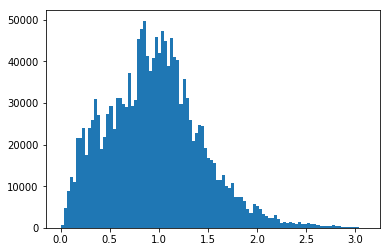

In [9]:
# Check for stars
plt.hist(gc_df['redshift'], bins=100);

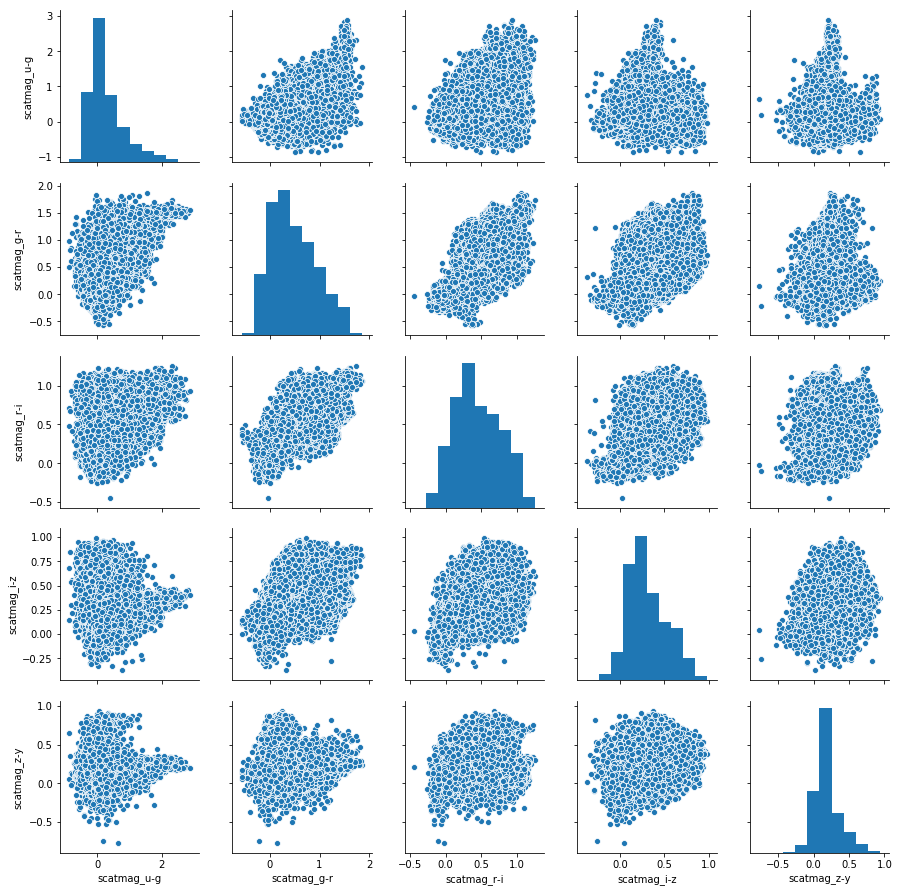

In [15]:
# Magnitude cuts look reasonable...
sns.pairplot(gc_df[['scatmag_u-g', 'scatmag_g-r', 'scatmag_r-i', 'scatmag_i-z', 'scatmag_z-y']][::100]);

#### Divide catalog into training and test sets:

In [9]:
# Make train/test split to be roughly 70%/30%:
int(.7 * gc_size)

1129234

In [11]:
train_mask = np.zeros(gc_size, dtype=bool)
train_size = int(.7 * gc_size)
train_indices = rng.choice(gc_size, size=train_size, replace=False)
train_mask[train_indices] = True

In [12]:
train = gc_df.loc[train_mask]
test = gc_df.loc[~train_mask]

print(len(train), len(test))

1129234 483958


#### 1) Build a SOM from a training subset of the catalog

- Use truth colors for training

- Note on choice of features: pheno-z paper uses 8 lupticolors (based on asinh magnitudes) all with respect to i-band

- For this example, use all truth colors

In [29]:
train_features = ['u-g_true', 'g-r_true', 'r-i_true', 'i-z_true', 'z-y_true']
train_array = train[train_features].to_numpy()

In [30]:
train_array = train_array[::3]
train_array.shape

(376412, 5)

In [31]:
train_array[:,:3].shape

(376412, 3)

In [32]:
!pwd

/global/cscratch1/sd/belaa/lsst/repos/pz_bayes/notebooks


Is it the neighborhood function that's getting worse, not the learning rate?

1.0 2.547564980363843
0.9969942259639334 2.28335405541525
0.9939974866054228 2.056533837675699
0.9910097547682687 1.861285846500904
0.9880310033778976 1.6927970903363025
0.9850612054411155 1.54707492283181
0.9821003340458642 1.4207982152527967
0.9791483623609768 1.3111973805946344
0.9762052636359351 1.2159573906660188
0.9732710112006266 1.1331391748720359
0.9703455784651036 1.061115761398198
0.9674289389193411 0.9985202811085374
0.9645210661329979 0.9442035499525846
0.9616219337551761 0.8971994139765945
0.9587315155141827 0.8566964105465374
0.9558497852172915 0.8220145920003751
0.9529767167505055 0.7925865905814469
0.9501122840783208 0.7679421893013741
0.9472564612434904 0.7476958125788836
Loss function getting worse at iteration 18
0.9444092223667884 0.7315364711192432
Loss function getting worse at iteration 19
0.9415705416467764 0.7192197938556917
0.9387403933595694 0.7105618608869397
0.9359187518586023 0.7054346192409184
0.9331055915743979 0.7037627212548281
0.930300887014335 0.705

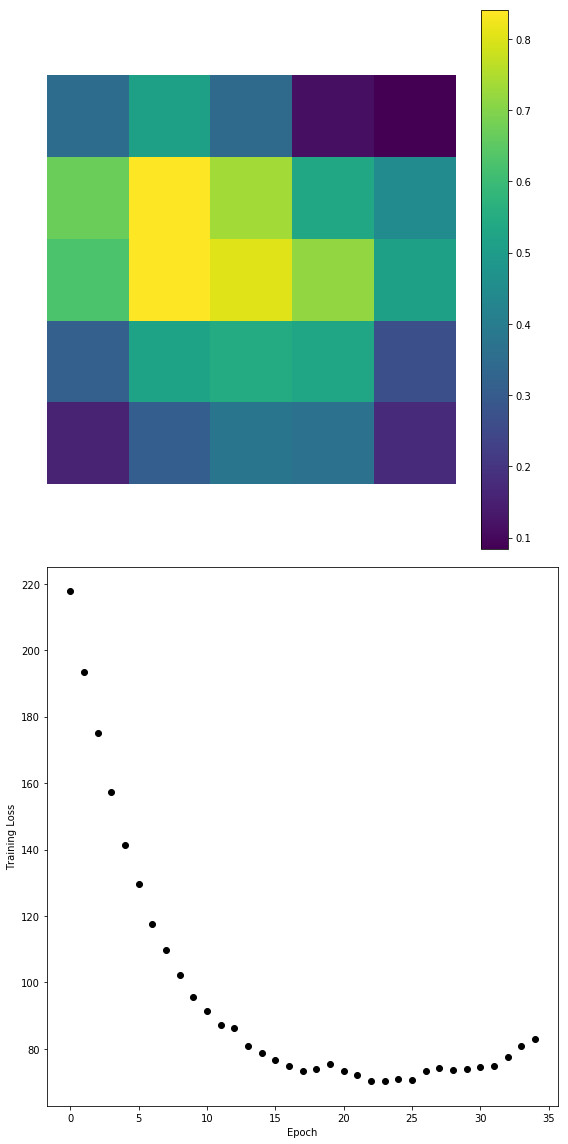

In [24]:
start = time.time()
temp_weights, temp_som = som.make_som(train_array[:1500,:2], nmap=5, eta=0.9, niter=35)
print(time.time()-start)

In [27]:
n_deep = int(131e3)

rndm_deep = rng.uniform(high=10.0, size=(n_deep,5))

1.0 38.26270084095022
0.9978950082958632 33.13814179282247
0.9957944475818009 28.783095335390236
0.9936983085306157 25.07284726102537
0.9916065818347439 21.90416128118423
0.9895192582062144 19.19138936071542
0.9874363283766067 16.863317593479383
0.9853577830970106 14.860603152330901
0.9832836131379848 13.133687197256101
0.9812138092895157 11.641091828239881
0.9791483623609768 10.348027548411448
0.9770872631810879 9.225252289732303
0.9750305025978738 8.2481346531233
0.972978071478625 7.395883257148587
0.9709299607098555 6.650911467549545
0.9688861611972633 5.998312681349753
0.9668466638656902 5.425426068539853
0.9648114596590806 4.921476471519626
0.9627805395404421 4.477275217004814
0.960753894491805 4.084971056858475
0.9587315155141827 3.7378424420241374
0.9567133936275308 3.4301239416795264
0.9546995198707083 3.1568609228552122
0.9526898853014371 2.913787663792057
0.9506844809962626 2.6972249349087516
0.9486832980505138 2.5039937825262086
0.9466863275782643 2.331342822974018
0.9446935

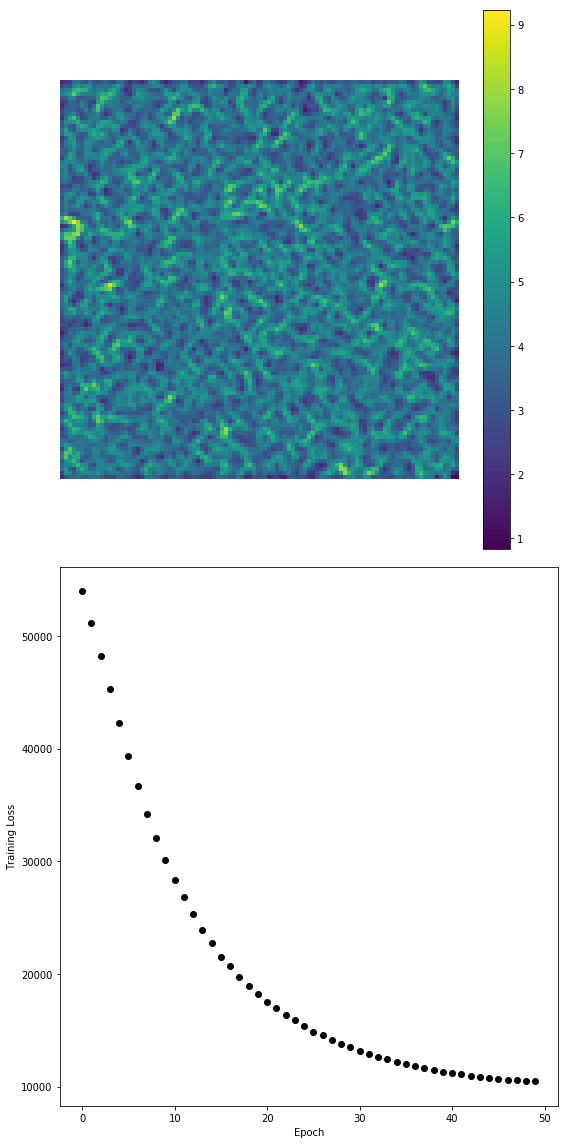

In [28]:
temp_weights, temp_som = som.make_som(rndm_deep[::15], nmap=-100, eta=0.9, niter=50)

In [13]:
start = time.time()
temp_weights, temp_evol_weights, temp_som = som.make_som(train_array[:150000], nmap=-5, eta=0.2, niter=15, evolve_freq=3)
print(time.time()-start)

TypeError: make_som() got an unexpected keyword argument 'evolve_freq'

1.0
0.8982598737615997
0.806870800810205
0.7247796636776955
0.6510404892001015
0.5848035476425733
0.5253055608807534
0.4718609068030119
0.42385371857790743
0.3807307877431757
0.34199518933533946
0.3072005555994364
Loss function getting worse at iteration 11
0.27594593229224296
Loss function getting worse at iteration 12
0.2478711583058571
Loss function getting worse at iteration 13
0.2226527153689607
Loss function getting worse at iteration 14
70.11265993118286


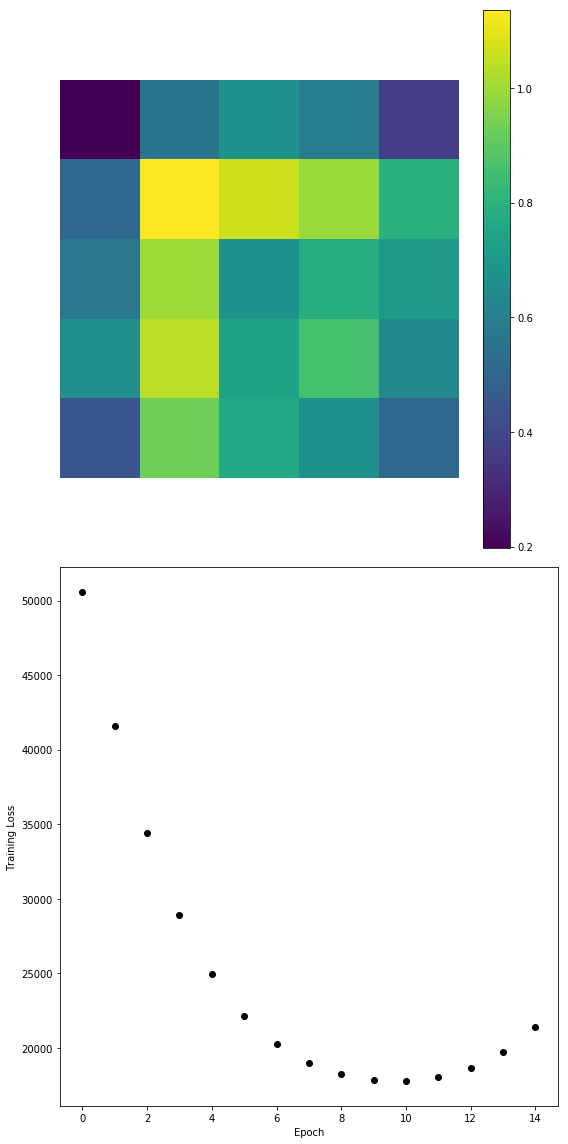

In [22]:
start = time.time()
temp_weights, temp_evol_weights, temp_som = som.make_som(train_array[:150000], nmap=-5, eta=0.2, niter=15, evolve_freq=3)
print(time.time()-start)

In [23]:
rows, cols, D = temp_som.shape

0.07123780250549316


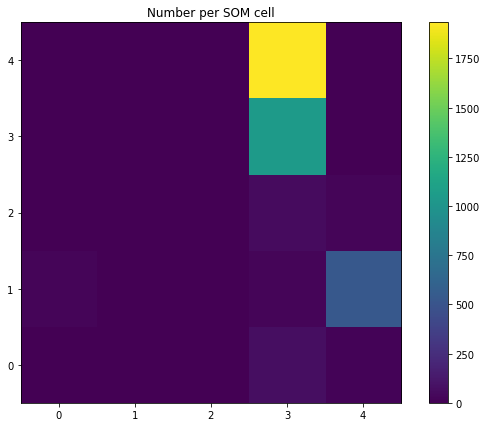

In [24]:
start = time.time()
som_evol_weights = temp_evol_weights[:,:,0]
temp_indices, temp_counts = som.map_phot_to_som(train_array[::100], som_evol_weights.reshape(rows,cols,D))
print(time.time() - start)
som.plot_counts_per_cell(temp_indices, temp_counts, rows, cols)

0.07865428924560547


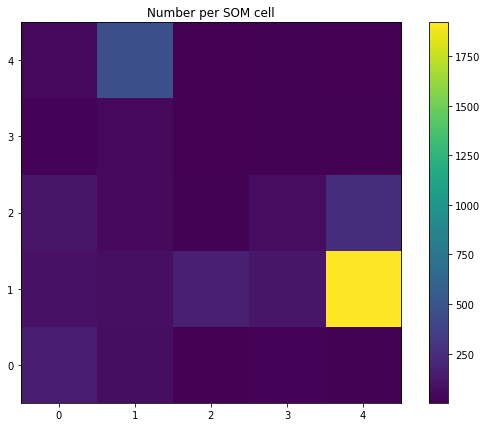

In [25]:
start = time.time()
som_evol_weights = temp_evol_weights[:,:,1]
temp_indices, temp_counts = som.map_phot_to_som(train_array[::100], som_evol_weights.reshape(rows,cols,D))
print(time.time() - start)
som.plot_counts_per_cell(temp_indices, temp_counts, rows, cols)

0.0639033317565918


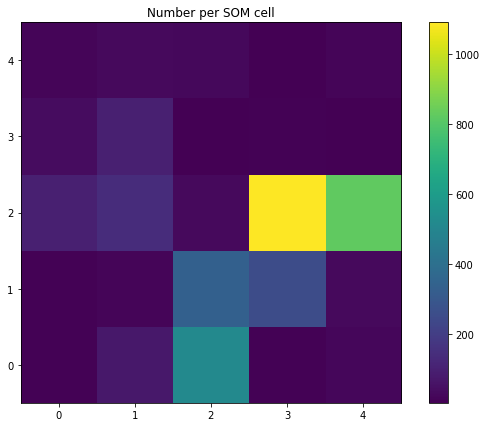

In [26]:
start = time.time()
som_evol_weights = temp_evol_weights[:,:,2]
temp_indices, temp_counts = som.map_phot_to_som(train_array[::100], som_evol_weights.reshape(rows,cols,D))
print(time.time() - start)
som.plot_counts_per_cell(temp_indices, temp_counts, rows, cols)

0.06282877922058105


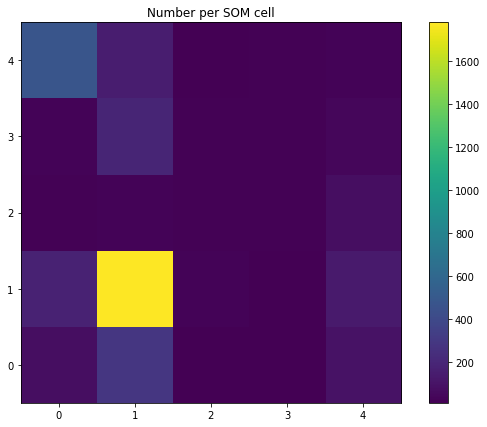

In [28]:
start = time.time()
som_evol_weights = temp_evol_weights[:,:,3]
temp_indices, temp_counts = som.map_phot_to_som(train_array[::100], som_evol_weights.reshape(rows,cols,D))
print(time.time() - start)
som.plot_counts_per_cell(temp_indices, temp_counts, rows, cols)

0.06342339515686035


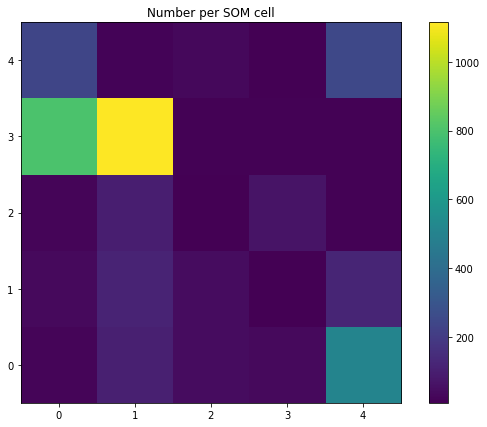

In [29]:
start = time.time()
som_evol_weights = temp_evol_weights[:,:,4]
temp_indices, temp_counts = som.map_phot_to_som(train_array[::100], som_evol_weights.reshape(rows,cols,D))
print(time.time() - start)
som.plot_counts_per_cell(temp_indices, temp_counts, rows, cols)

0.06289005279541016


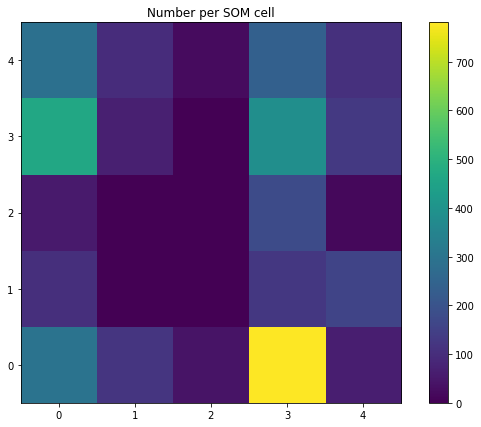

In [27]:
start = time.time()
temp_indices, temp_counts = som.map_phot_to_som(train_array[::100], temp_weights.reshape(rows,cols,D))
print(time.time() - start)
som.plot_counts_per_cell(temp_indices, temp_counts, rows, cols)

Loss function getting worse at iteration 12
Loss function getting worse at iteration 13
Loss function getting worse at iteration 14
3.4693946838378906


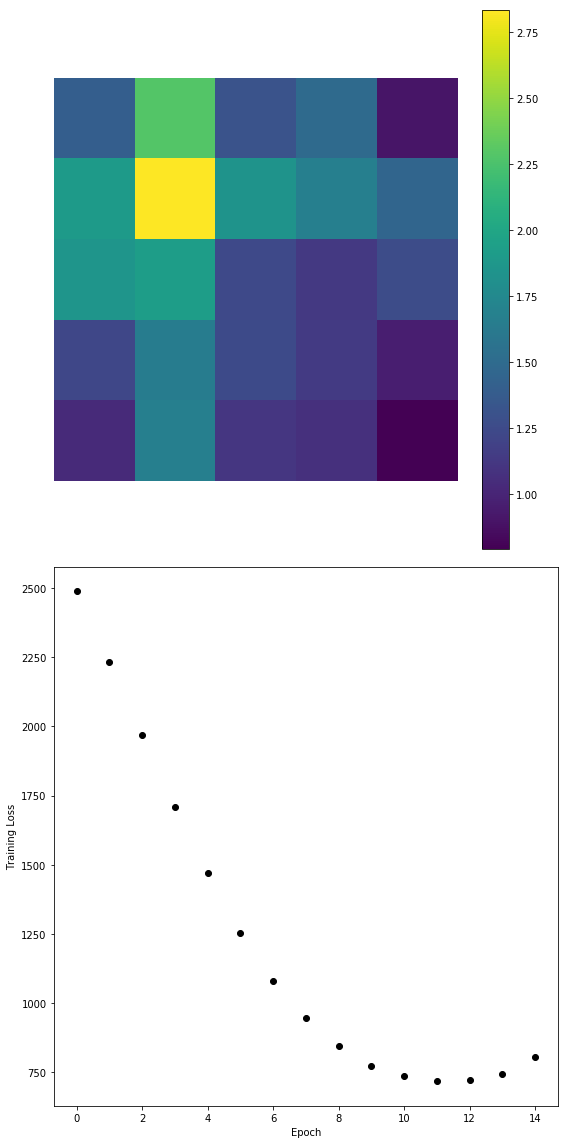

In [14]:
start = time.time()
temp_weights, temp_evol_weights, temp_som = som.make_som(train_array[:8000], nmap=-5, niter=15, evolve_freq=5)
print(time.time()-start)

In [14]:
# n_cells, n_weights, n_evolution_cycles
temp_evol_weights.shape

(900, 5, 1)

In [15]:
rows, cols, D = temp_som.shape

11.31661343574524


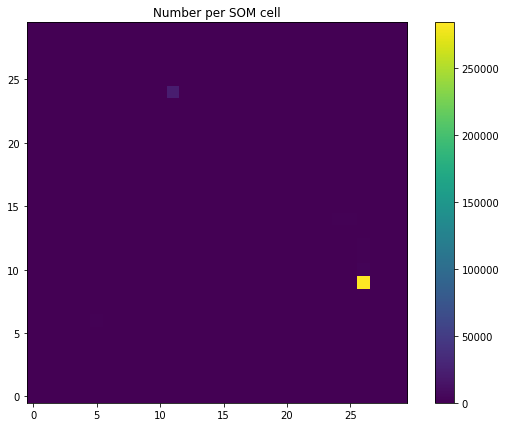

In [16]:
start = time.time()
som_evol_weights = temp_evol_weights[:,:,0]
temp_indices, temp_counts = som.map_phot_to_som(train_array, som_evol_weights.reshape(rows,cols,5))
print(time.time() - start)
som.plot_counts_per_cell(temp_indices, temp_counts, rows, cols)

6.038040399551392


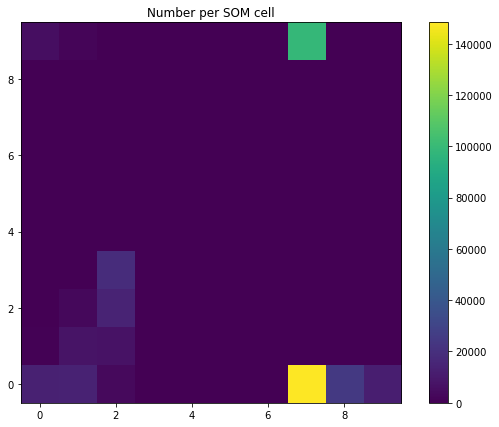

In [23]:
start = time.time()
som_evol_weights = temp_evol_weights[:,:,1]
temp_indices, temp_counts = som.map_phot_to_som(train_array, som_evol_weights.reshape(rows,cols,5))
print(time.time() - start)
som.plot_counts_per_cell(temp_indices, temp_counts, rows, cols)

5.934137344360352


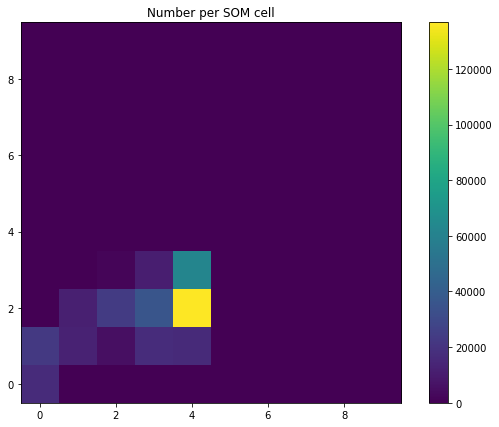

In [24]:
start = time.time()
som_evol_weights = temp_evol_weights[:,:,2]
temp_indices, temp_counts = som.map_phot_to_som(train_array, som_evol_weights.reshape(rows,cols,5))
print(time.time() - start)
som.plot_counts_per_cell(temp_indices, temp_counts, rows, cols)

6.426162481307983


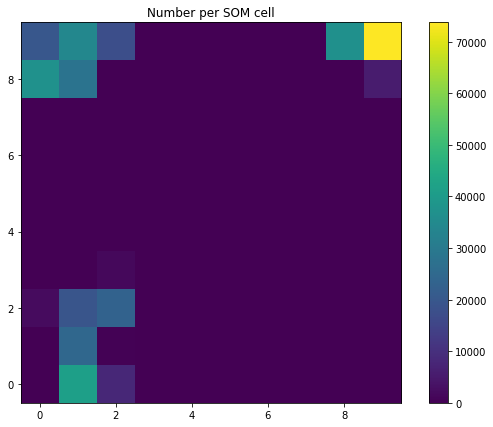

In [25]:
start = time.time()
som_evol_weights = temp_evol_weights[:,:,3]
temp_indices, temp_counts = som.map_phot_to_som(train_array, som_evol_weights.reshape(rows,cols,5))
print(time.time() - start)
som.plot_counts_per_cell(temp_indices, temp_counts, rows, cols)

6.243064880371094


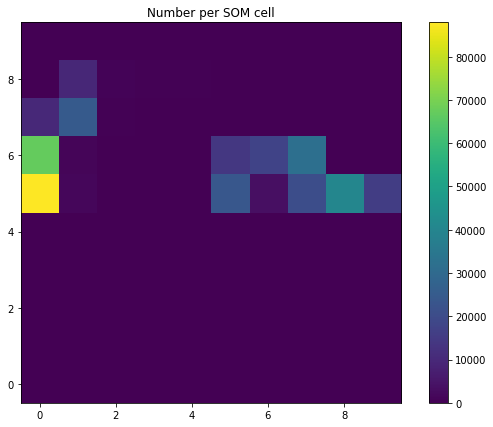

In [26]:
start = time.time()
som_evol_weights = temp_evol_weights[:,:,4]
temp_indices, temp_counts = som.map_phot_to_som(train_array, som_evol_weights.reshape(rows,cols,5))
print(time.time() - start)
som.plot_counts_per_cell(temp_indices, temp_counts, rows, cols)

6.637907266616821


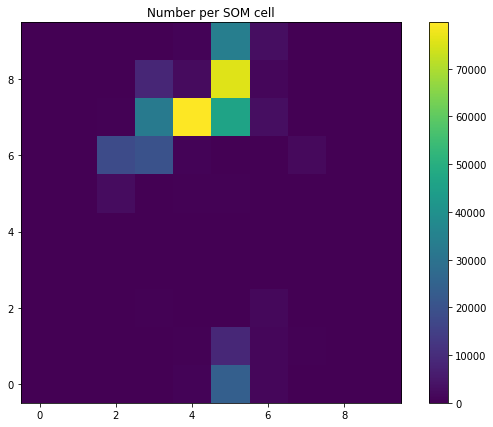

In [27]:
start = time.time()
som_evol_weights = temp_evol_weights[:,:,5]
temp_indices, temp_counts = som.map_phot_to_som(train_array, som_evol_weights.reshape(rows,cols,5))
print(time.time() - start)
som.plot_counts_per_cell(temp_indices, temp_counts, rows, cols)

6.339542627334595


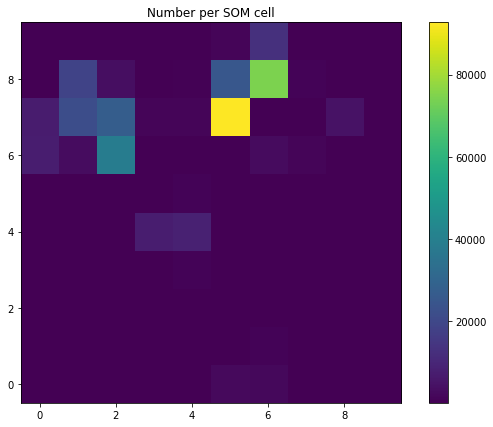

In [28]:
start = time.time()
som_evol_weights = temp_evol_weights[:,:,6]
temp_indices, temp_counts = som.map_phot_to_som(train_array, som_evol_weights.reshape(rows,cols,5))
print(time.time() - start)
som.plot_counts_per_cell(temp_indices, temp_counts, rows, cols)

6.41561222076416


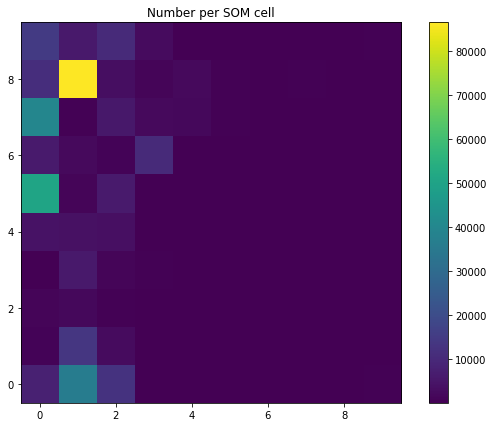

In [29]:
start = time.time()
som_evol_weights = temp_evol_weights[:,:,7]
temp_indices, temp_counts = som.map_phot_to_som(train_array, som_evol_weights.reshape(rows,cols,5))
print(time.time() - start)
som.plot_counts_per_cell(temp_indices, temp_counts, rows, cols)

6.073908090591431


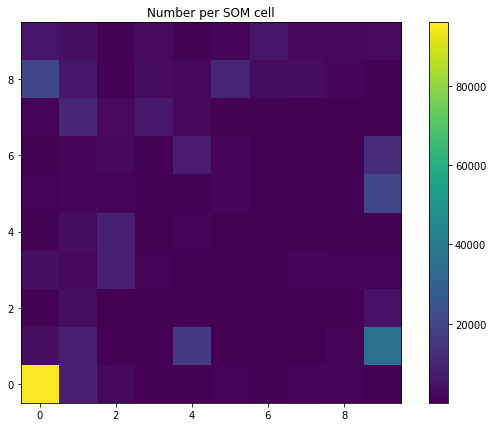

In [30]:
start = time.time()
som_evol_weights = temp_evol_weights[:,:,8]
temp_indices, temp_counts = som.map_phot_to_som(train_array, som_evol_weights.reshape(rows,cols,5))
print(time.time() - start)
som.plot_counts_per_cell(temp_indices, temp_counts, rows, cols)

6.143037557601929


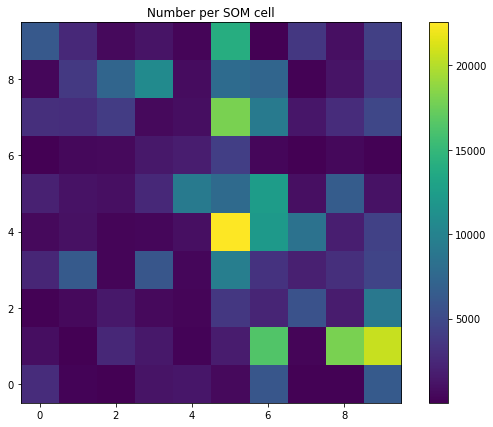

In [31]:
start = time.time()
som_evol_weights = temp_evol_weights[:,:,9]
temp_indices, temp_counts = som.map_phot_to_som(train_array, som_evol_weights.reshape(rows,cols,5))
print(time.time() - start)
som.plot_counts_per_cell(temp_indices, temp_counts, rows, cols)

5.800246477127075


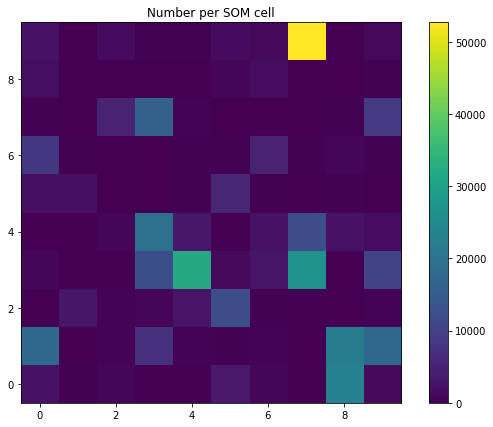

In [32]:
start = time.time()
temp_indices, temp_counts = som.map_phot_to_som(train_array, temp_weights.reshape(rows,cols,5))
print(time.time() - start)
som.plot_counts_per_cell(temp_indices, temp_counts, rows, cols)

400.36208152770996


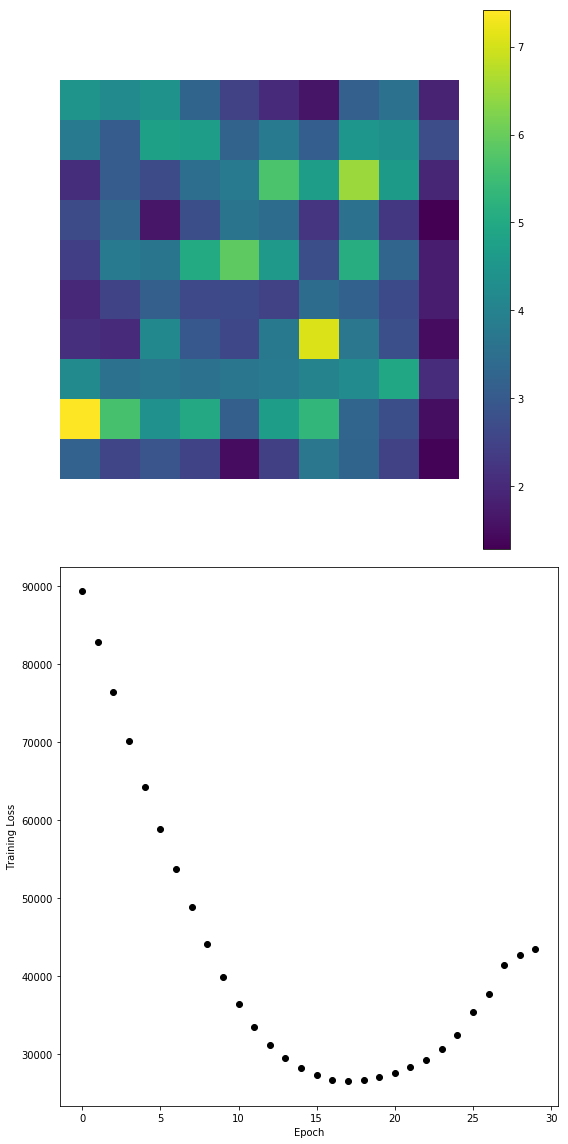

In [34]:
start = time.time()
temp_weights, temp_evol_weights, temp_som = som.make_som(train_array, nmap=-10, niter=30, evolve_freq=2)
print(time.time()-start)

In [53]:
for i, j in enumerate(train_array[:4]):
    #print(i,j.reshape(-1,1).shape)
    print(np.sum(j.reshape(-1,1), axis=0).shape)

(1,)
(1,)
(1,)
(1,)


In [55]:
ppp = rng.normal(size=(D, 100))

In [63]:
np.sqrt(np.sum((j.reshape(-1,1) - ppp)**2, axis=0)[np.argmin(np.sum((j.reshape(-1,1) - ppp)**2, axis=0))])

0.8937220525473051

In [35]:
rows, cols, D = temp_som.shape

11.467015981674194


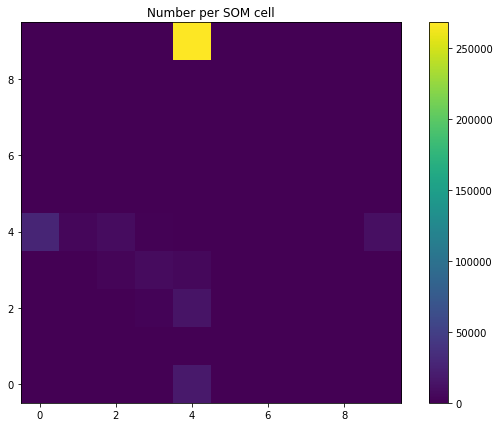

In [36]:
start = time.time()
som_evol_weights = temp_evol_weights[:,:,0]
temp_indices, temp_counts = som.map_phot_to_som(train_array, som_evol_weights.reshape(rows,cols,5))
print(time.time() - start)
som.plot_counts_per_cell(temp_indices, temp_counts, rows, cols)

10.739118099212646


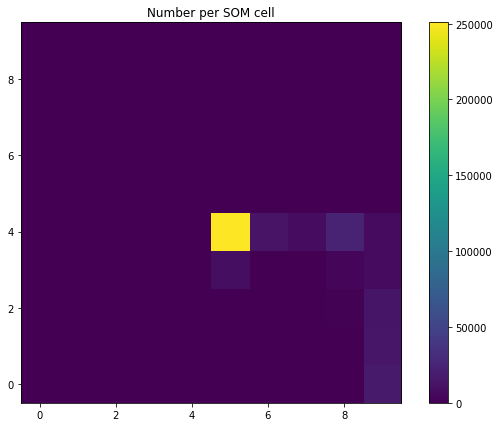

In [37]:
start = time.time()
som_evol_weights = temp_evol_weights[:,:,1]
temp_indices, temp_counts = som.map_phot_to_som(train_array, som_evol_weights.reshape(rows,cols,5))
print(time.time() - start)
som.plot_counts_per_cell(temp_indices, temp_counts, rows, cols)

11.241352558135986


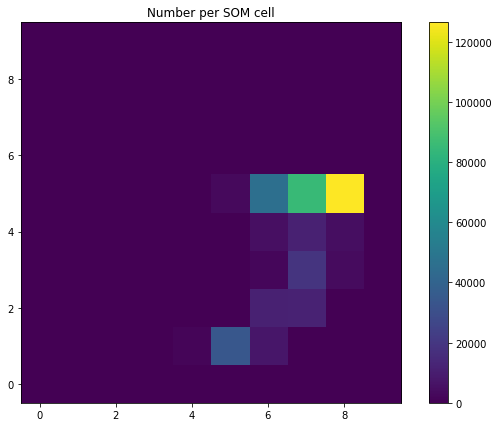

In [38]:
start = time.time()
som_evol_weights = temp_evol_weights[:,:,2]
temp_indices, temp_counts = som.map_phot_to_som(train_array, som_evol_weights.reshape(rows,cols,5))
print(time.time() - start)
som.plot_counts_per_cell(temp_indices, temp_counts, rows, cols)

12.268580198287964


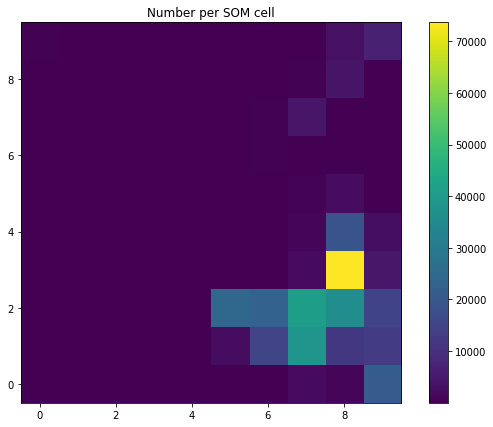

In [41]:
start = time.time()
som_evol_weights = temp_evol_weights[:,:,7]
temp_indices, temp_counts = som.map_phot_to_som(train_array, som_evol_weights.reshape(rows,cols,5))
print(time.time() - start)
som.plot_counts_per_cell(temp_indices, temp_counts, rows, cols)

12.80678415298462


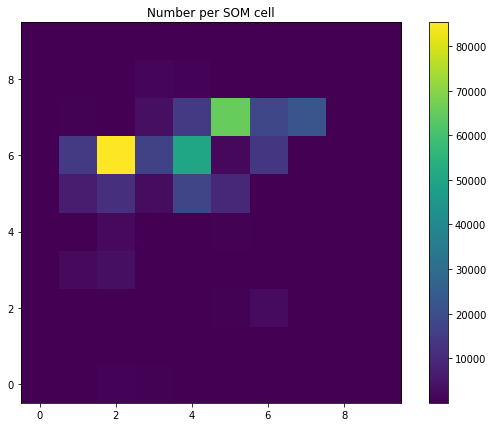

In [42]:
start = time.time()
som_evol_weights = temp_evol_weights[:,:,9]
temp_indices, temp_counts = som.map_phot_to_som(train_array, som_evol_weights.reshape(rows,cols,5))
print(time.time() - start)
som.plot_counts_per_cell(temp_indices, temp_counts, rows, cols)

12.670835018157959


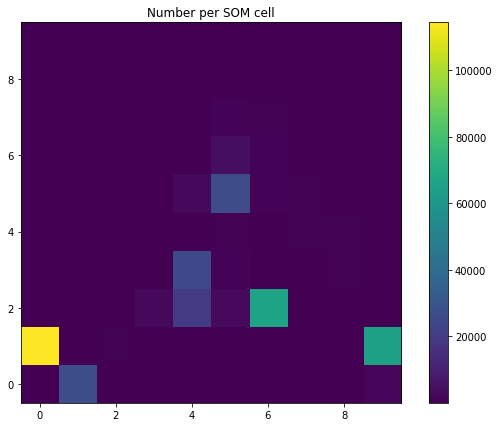

In [43]:
start = time.time()
som_evol_weights = temp_evol_weights[:,:,10]
temp_indices, temp_counts = som.map_phot_to_som(train_array, som_evol_weights.reshape(rows,cols,5))
print(time.time() - start)
som.plot_counts_per_cell(temp_indices, temp_counts, rows, cols)

11.666117906570435


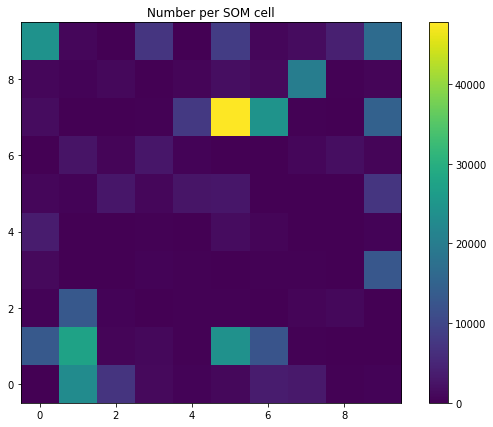

In [44]:
start = time.time()
temp_indices, temp_counts = som.map_phot_to_som(train_array, temp_weights.reshape(temp_som.shape))
print(time.time() - start)
som.plot_counts_per_cell(temp_indices, temp_counts, rows, cols)

Cell above is at epoch 15, cell below is at epoch 18 - there seems to be a connection between the bend at the knee of the loss plot and the fact that the training gets slighly worse after around epoch 17-18 (where the knee is).

18.646318197250366


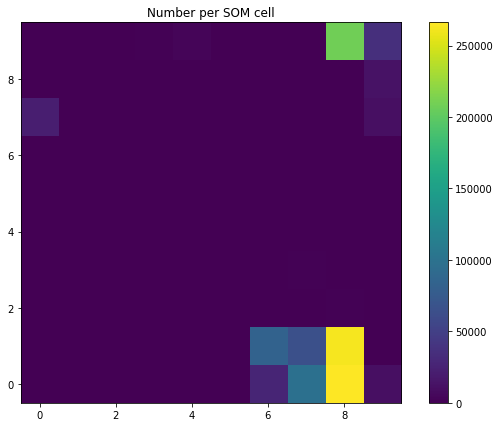

In [22]:
start = time.time()
som_evol_weights = temp_evol_weights[:,:,5]
temp_indices, temp_counts = som.map_phot_to_som(train_array, som_evol_weights.reshape(rows,cols,5))
print(time.time() - start)
som.plot_counts_per_cell(temp_indices, temp_counts, rows, cols)

18.658539056777954


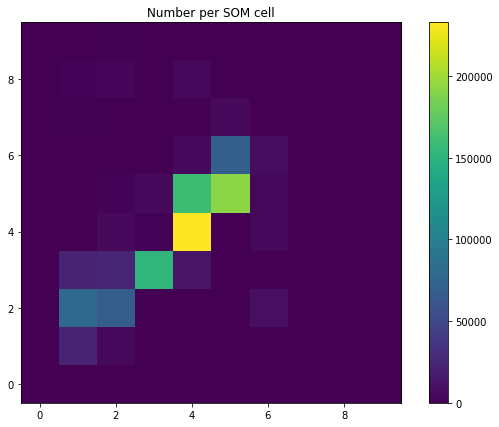

In [23]:
start = time.time()
som_evol_weights = temp_evol_weights[:,:,6]
temp_indices, temp_counts = som.map_phot_to_som(train_array, som_evol_weights.reshape(rows,cols,5))
print(time.time() - start)
som.plot_counts_per_cell(temp_indices, temp_counts, rows, cols)

17.877875328063965


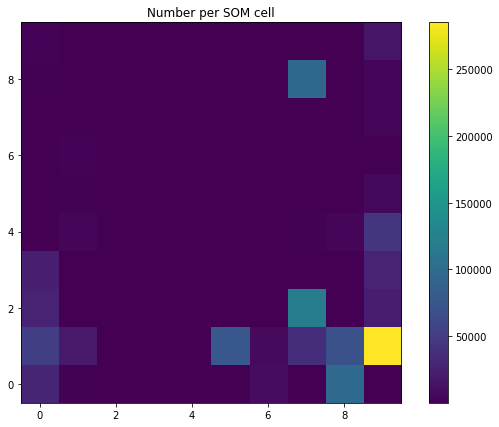

In [24]:
start = time.time()
som_evol_weights = temp_evol_weights[:,:,7]
temp_indices, temp_counts = som.map_phot_to_som(train_array, som_evol_weights.reshape(rows,cols,5))
print(time.time() - start)
som.plot_counts_per_cell(temp_indices, temp_counts, rows, cols)

22.256588459014893


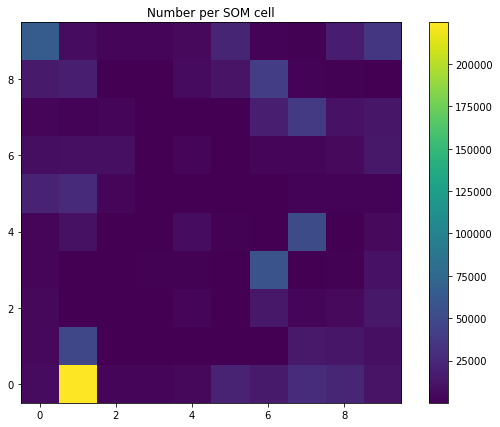

In [25]:
start = time.time()
som_evol_weights = temp_evol_weights[:,:,8]
temp_indices, temp_counts = som.map_phot_to_som(train_array, som_evol_weights.reshape(rows,cols,5))
print(time.time() - start)
som.plot_counts_per_cell(temp_indices, temp_counts, rows, cols)

22.90284276008606


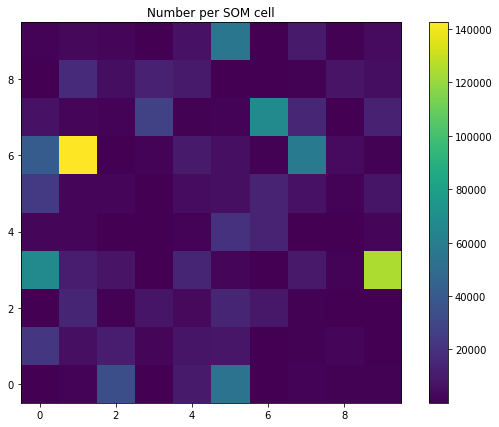

In [26]:
start = time.time()
som_evol_weights = temp_evol_weights[:,:,9]
temp_indices, temp_counts = som.map_phot_to_som(train_array, som_evol_weights.reshape(rows,cols,5))
print(time.time() - start)
som.plot_counts_per_cell(temp_indices, temp_counts, rows, cols)

20.599782466888428


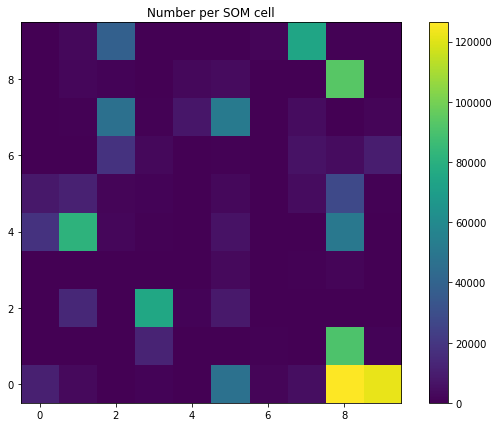

In [28]:
start = time.time()
temp_indices, temp_counts = som.map_phot_to_som(train_array, temp_weights.reshape(temp_som.shape))
print(time.time() - start)
som.plot_counts_per_cell(temp_indices, temp_counts, rows, cols)

11.851299047470093


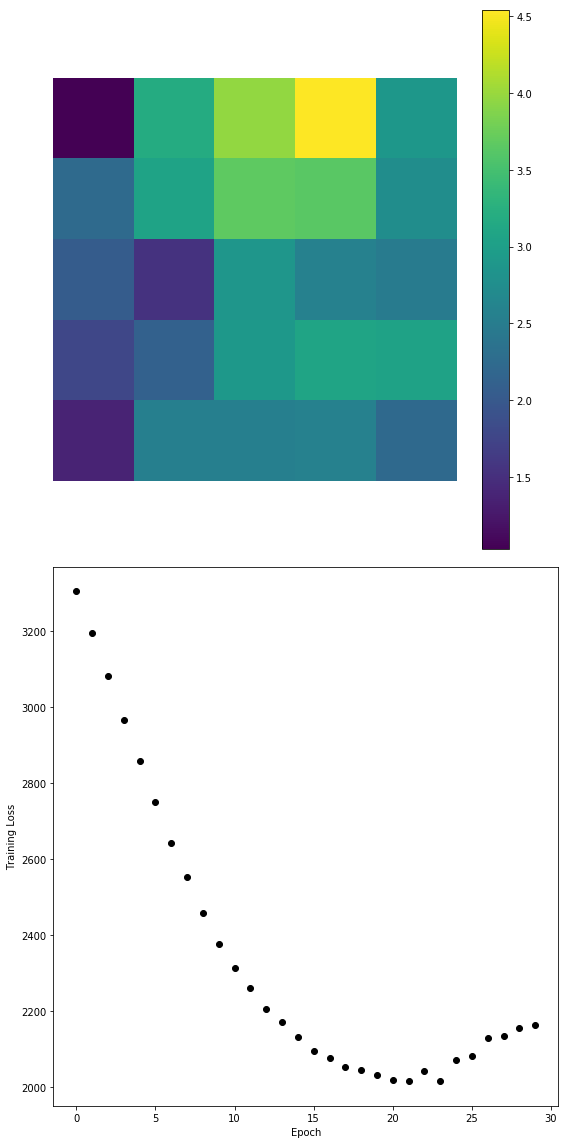

In [32]:
start = time.time()
temp_weights, temp_evol_weights, temp_som = som.make_som(train_array[::100], nmap=-5, niter=30, evolve_freq=3)
print(time.time()-start)

In [33]:
rows, cols, D = temp_som.shape

0.19776535034179688


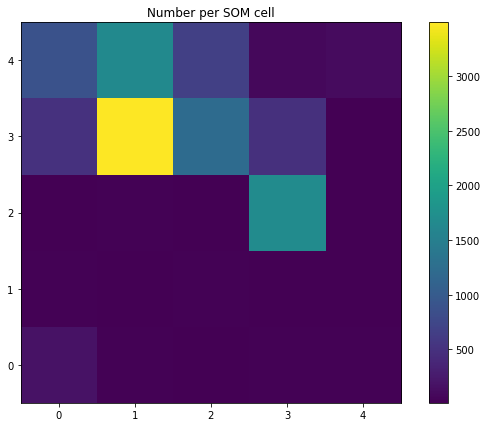

In [42]:
start = time.time()
som_evol_weights = temp_evol_weights[:,:,6]
temp_indices, temp_counts = som.map_phot_to_som(train_array[::100], som_evol_weights.reshape(rows,cols,5))
print(time.time() - start)
som.plot_counts_per_cell(temp_indices, temp_counts, rows, cols)

0.20001935958862305


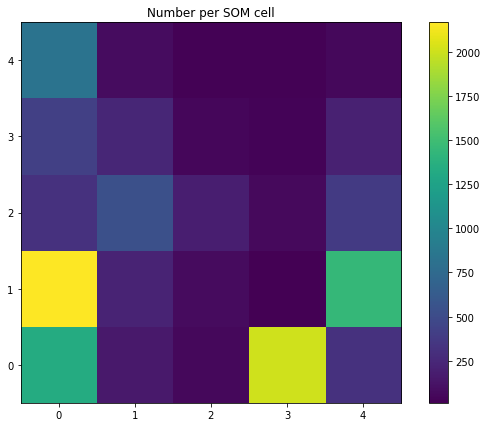

In [43]:
start = time.time()
som_evol_weights = temp_evol_weights[:,:,7]
temp_indices, temp_counts = som.map_phot_to_som(train_array[::100], som_evol_weights.reshape(rows,cols,5))
print(time.time() - start)
som.plot_counts_per_cell(temp_indices, temp_counts, rows, cols)

0.20473718643188477


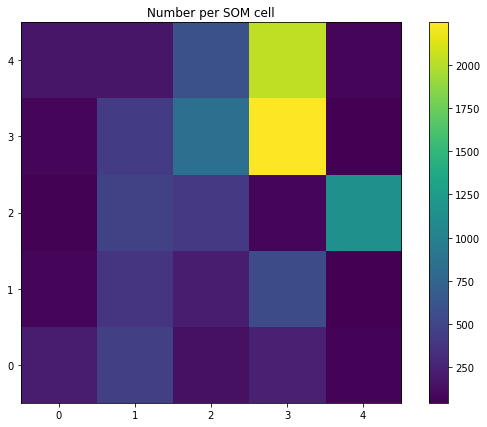

In [44]:
start = time.time()
som_evol_weights = temp_evol_weights[:,:,8]
temp_indices, temp_counts = som.map_phot_to_som(train_array[::100], som_evol_weights.reshape(rows,cols,5))
print(time.time() - start)
som.plot_counts_per_cell(temp_indices, temp_counts, rows, cols)

0.2335364818572998


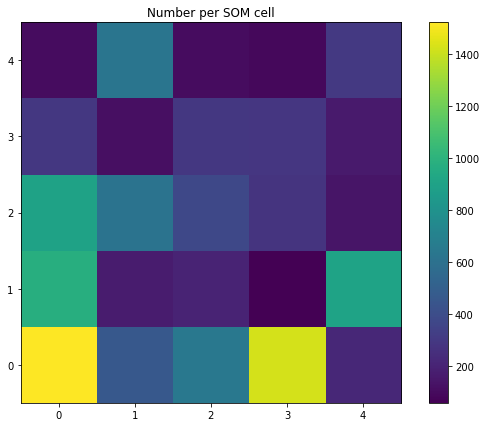

In [48]:
start = time.time()
som_evol_weights = temp_evol_weights[:,:,9]
temp_indices, temp_counts = som.map_phot_to_som(train_array[::100], som_evol_weights.reshape(rows,cols,5))
print(time.time() - start)
som.plot_counts_per_cell(temp_indices, temp_counts, rows, cols)

0.1902146339416504


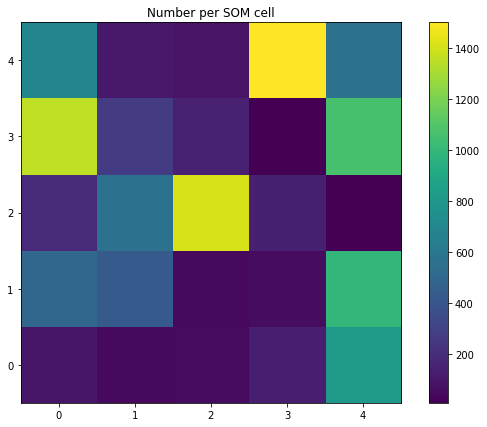

In [46]:
start = time.time()
temp_indices, temp_counts = som.map_phot_to_som(train_array[::100], temp_weights.reshape(temp_som.shape))
print(time.time() - start)
som.plot_counts_per_cell(temp_indices, temp_counts, rows, cols)

1.9893312454223633


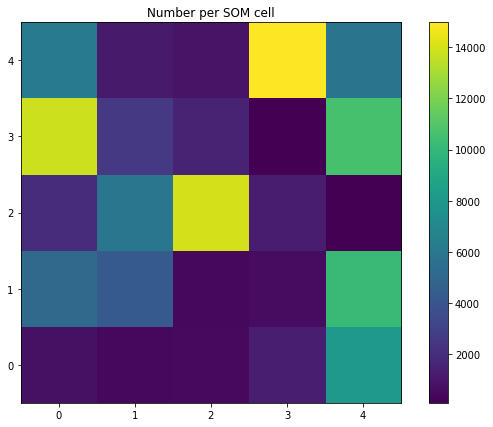

In [49]:
start = time.time()
temp_indices, temp_counts = som.map_phot_to_som(train_array[::10], temp_weights.reshape(temp_som.shape))
print(time.time() - start)
som.plot_counts_per_cell(temp_indices, temp_counts, rows, cols)

16.402202129364014


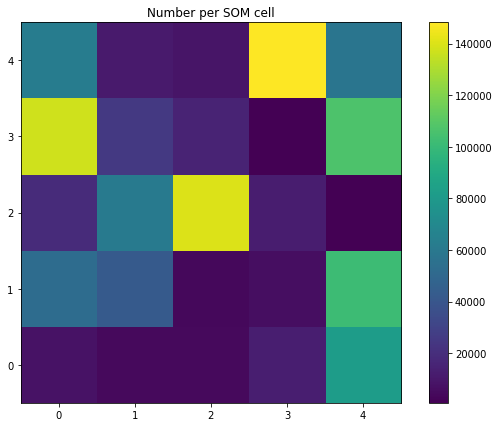

In [50]:
start = time.time()
temp_indices, temp_counts = som.map_phot_to_som(train_array, temp_weights.reshape(temp_som.shape))
print(time.time() - start)
som.plot_counts_per_cell(temp_indices, temp_counts, rows, cols)

#### 2) Map test set to training SOM

- Map true photometry to SOM as a sanity check

In [39]:
test_features = ['u-g_true', 'g-r_true', 'r-i_true', 'i-z_true', 'z-y_true']
test_array = test[test_features].to_numpy()

In [17]:
start = time.time()
temp_indices, temp_counts = som.map_phot_to_som(test_array, temp_som)
print(time.time() - start)

10.05152177810669


In [19]:
start = time.time()
temp_indices, temp_counts = som.map_phot_to_som(train_array, temp_som)
print(time.time() - start)

24.05432653427124


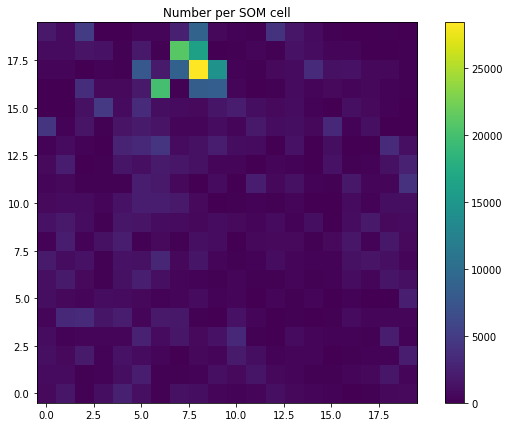

In [18]:
rows, cols, D = temp_som.shape
som.plot_counts_per_cell(temp_indices, temp_counts, rows, cols)

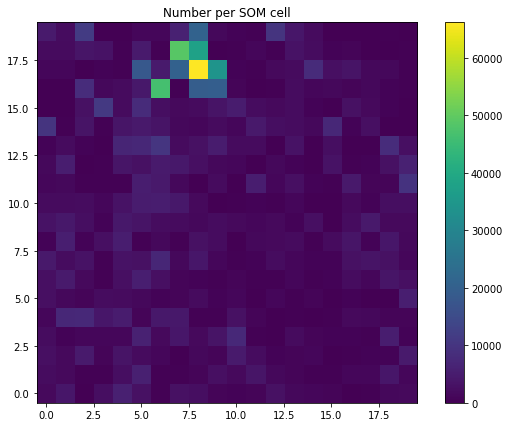

In [20]:
rows, cols, D = temp_som.shape
som.plot_counts_per_cell(temp_indices, temp_counts, rows, cols)

In [33]:
len(temp_counts) - np.count_nonzero(temp_counts), np.percentile(temp_counts, (5, 99))

(4, array([   80.75, 34370.29]))

In [34]:
80/65000

0.0012307692307692308

In [152]:
from matplotlib.colors import LogNorm

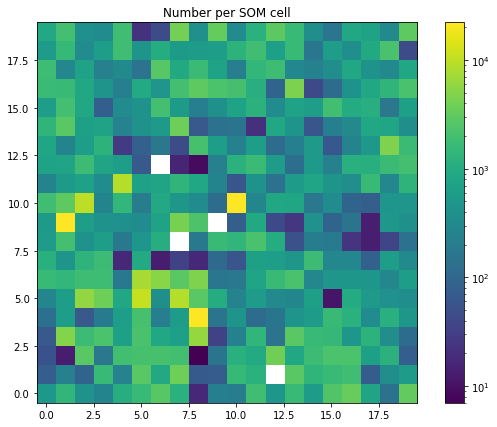

In [153]:
rows, cols, D = temp_som.shape
som.plot_counts_per_cell(temp_indices, temp_counts, rows, cols, norm=LogNorm())

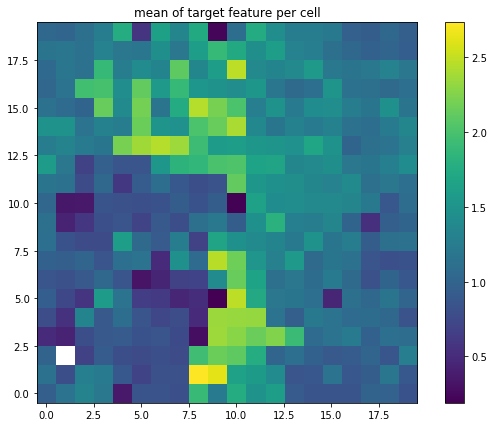

In [189]:
som.plot_statistic(temp_indices, temp_counts, test['redshift'], rows, cols, statistic=np.mean)

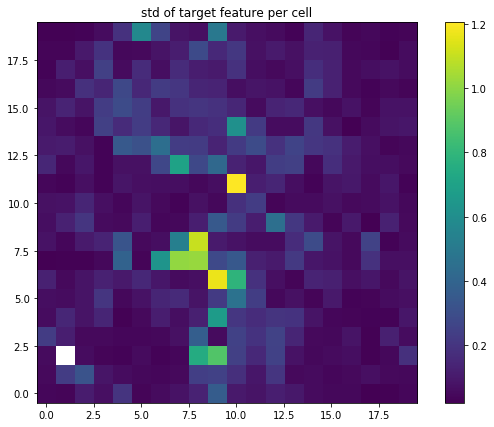

In [190]:
som.plot_statistic(temp_indices, temp_counts, test['redshift'], rows, cols, statistic=np.std)

Bin with highest density:

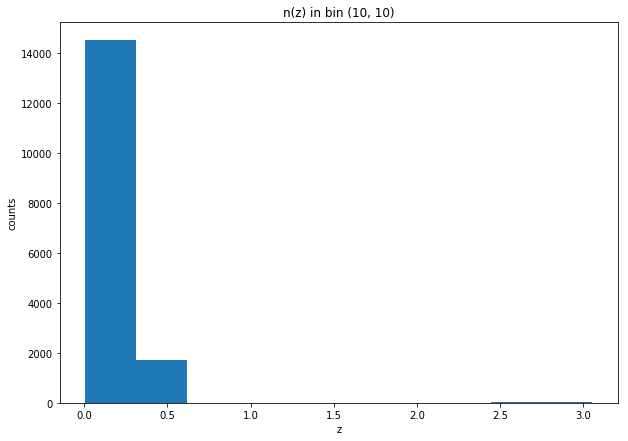

In [195]:
som.plot_dist_in_cell(temp_indices, test['redshift'], cols, idx=(10,10))

Bin with large mean:

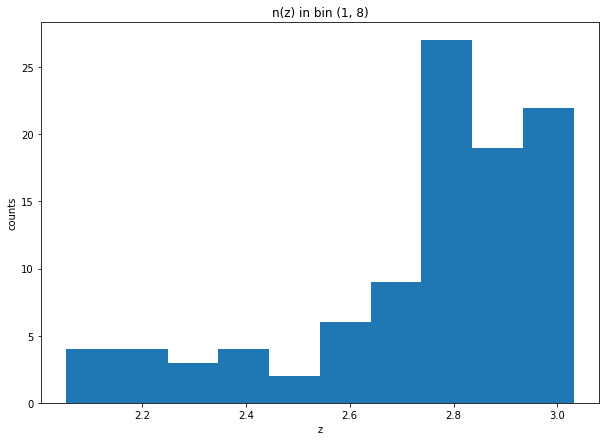

In [194]:
som.plot_dist_in_cell(temp_indices, test['redshift'], cols, idx=(1,8))

Bins with high variance:

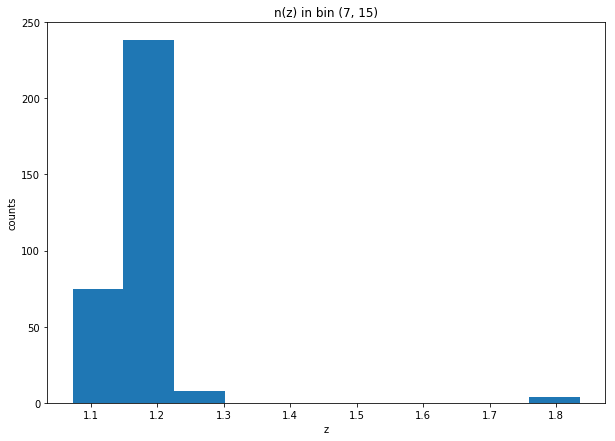

In [193]:
som.plot_dist_in_cell(temp_indices, test['redshift'], cols, idx=(7,15))

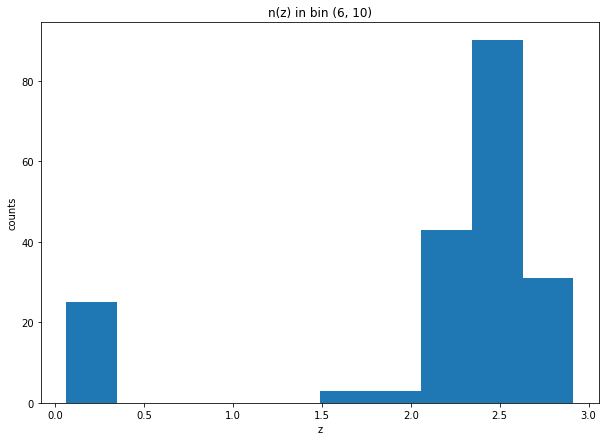

In [192]:
som.plot_dist_in_cell(temp_indices, test['redshift'], cols, idx=(6,10))

Map truth to SOM made from coarser grid:

In [15]:
start = time.time()
temp_indices, temp_counts = som.map_phot_to_som(test_array, temp_weights.reshape(5,5,5))
print(time.time() - start)

6.184394121170044


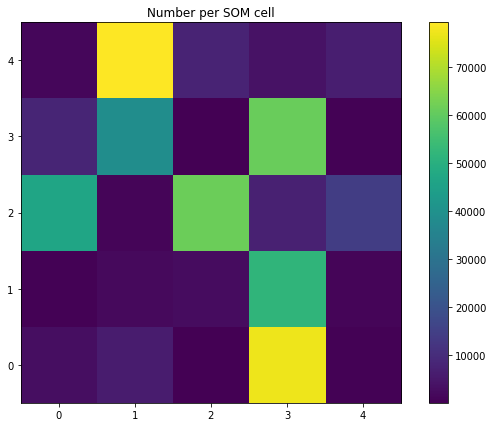

In [16]:
rows, cols, D = temp_som.shape
som.plot_counts_per_cell(temp_indices, temp_counts, rows, cols)

In [17]:
start = time.time()
temp_indices, temp_counts = som.map_phot_to_som(train_array, temp_weights.reshape(5,5,5))
print(time.time() - start)

13.167344093322754


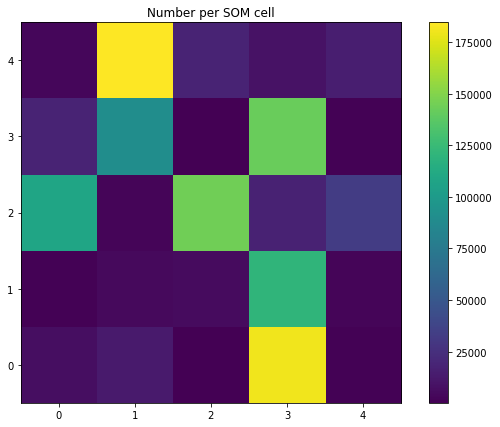

In [18]:
rows, cols, D = temp_som.shape
som.plot_counts_per_cell(temp_indices, temp_counts, rows, cols)

- Use observed colors from test set

In [154]:
test_features = ['scatmag_u-g', 'scatmag_g-r', 'scatmag_r-i', 'scatmag_i-z', 'scatmag_z-y']
test_array = test[test_features].to_numpy()

In [155]:
start = time.time()
temp_indices, temp_counts = som.map_phot_to_som(test_array, temp_som)
print(time.time() - start)

11.317936182022095


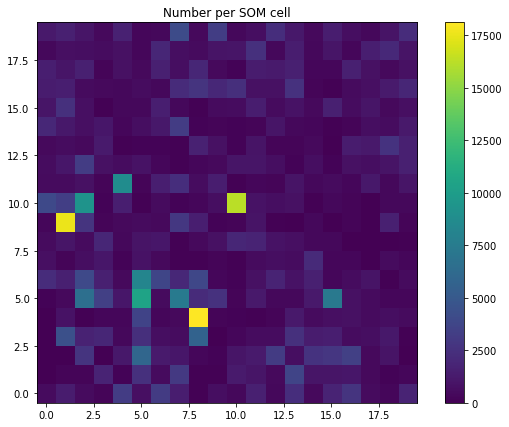

In [156]:
rows, cols, D = temp_som.shape
som.plot_counts_per_cell(temp_indices, temp_counts, rows, cols)

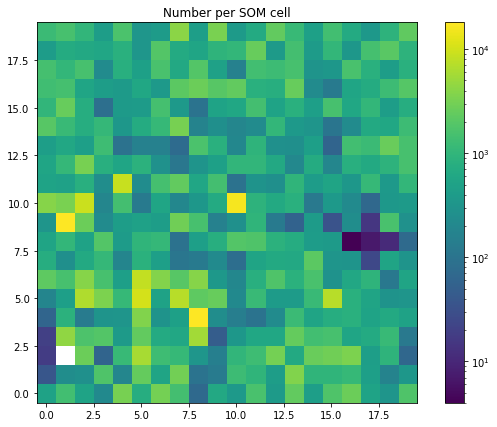

In [157]:
rows, cols, D = temp_som.shape
som.plot_counts_per_cell(temp_indices, temp_counts, rows, cols, norm=LogNorm())

In [158]:
test_som = np.load('/global/cscratch1/sd/belaa/lsst/pz/batch_scripts/som_output/dc2_small_10y_som_1100000_20_periodic.npy')
test_losses = np.load('/global/cscratch1/sd/belaa/lsst/pz/batch_scripts/som_output/dc2_small_10y_som_1100000_20_periodic_losses.npy')

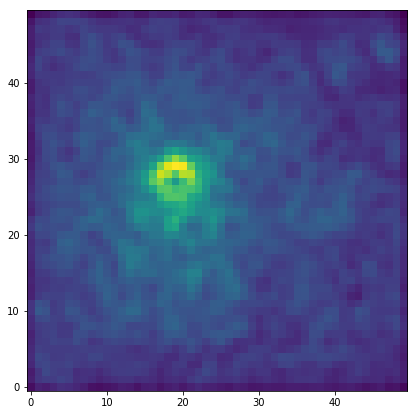

In [161]:
plt.figure(figsize=(10,7))
plt.imshow(som.u_matrix(test_som), origin='lower');

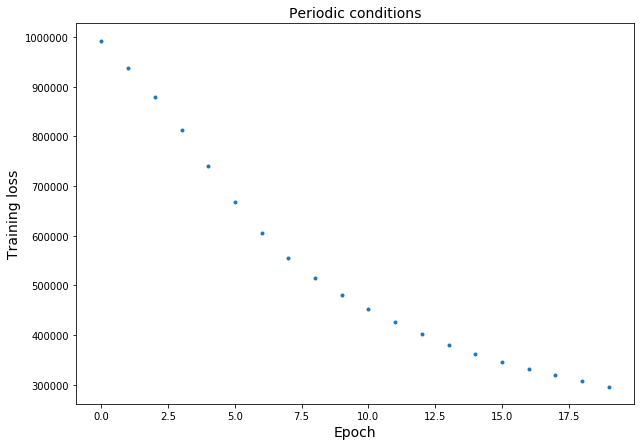

In [162]:
fs = 14
plt.figure(figsize=(10,7))
plt.plot(test_losses, '.')
plt.title('Periodic conditions', fontsize=fs)
plt.xlabel('Epoch', fontsize=fs)
plt.ylabel('Training loss', fontsize=fs);